### Load in time series objects of the Twitter, Google search, and FBI Hate-Crime datasets

Granger causality is based on the idea that if a variable X can be used to predict another variable Y better than Y can be predicted by its own past values, then X is said to Granger-cause Y. However, this does not necessarily mean that X causes Y in the sense of a direct causal relationship. 

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
import matplotlib.pyplot as plt

In [2]:
twitter_d = pd.read_csv('/Users/itsyuzhou/Spring2023/MACS30200/replication-materials-yuzhouw313/time series/ts_day_tweet.csv', index_col=0, parse_dates=True)
twitter_w = pd.read_csv('/Users/itsyuzhou/Spring2023/MACS30200/replication-materials-yuzhouw313/time series/ts_week_tweet.csv', index_col=0, parse_dates=True)
google_d_old = pd.read_csv('/Users/itsyuzhou/Spring2023/MACS30200/replication-materials-yuzhouw313/time series/ts_day_google_old.csv', index_col=0, parse_dates=True)
google_d_new = pd.read_csv('/Users/itsyuzhou/Spring2023/MACS30200/replication-materials-yuzhouw313/time series/ts_day_google_new.csv', index_col=0, parse_dates=True)
google_w_old = pd.read_csv('/Users/itsyuzhou/Spring2023/MACS30200/replication-materials-yuzhouw313/time series/ts_week_google_old.csv', index_col=0, parse_dates=True)
google_w_new = pd.read_csv('/Users/itsyuzhou/Spring2023/MACS30200/replication-materials-yuzhouw313/time series/ts_week_google_new.csv', index_col=0, parse_dates=True)
crime_w = pd.read_csv('/Users/itsyuzhou/Spring2023/MACS30200/replication-materials-yuzhouw313/time series/ts_week_crime.csv', index_col=0, parse_dates=True)

In [ ]:
def granger_table(res, lag_val):
    ''' 
    Helper function to write out and organize p-values for different tests on different lag values
    Input: The result for Granger Causality test from the previous step
    '''
    table = pd.DataFrame(columns=['Maxlags', 'ssr F p-value', 'ssr chi2 p-value', 
                                 'likelihoodratio p-value', 'param F p-value'])

    for lag in range(1, lag_val+1):
        test_results = res[lag][0]
        table = table.append({'Maxlags': lag, 
                                        'ssr F p-value': round(test_results['ssr_ftest'][1], 3),
                                        'ssr chi2 p-value': round(test_results['ssr_chi2test'][1], 3),
                                        'likelihoodratio p-value': round(test_results['lrtest'][1], 3),
                                        'param F p-value': round(test_results['params_ftest'][1], 3)},
                                        ignore_index=True)
    return table

## Granger Causality for daily Twitter and Google Search Time Series

### Create new time series of differenced daily Twitter, Google old, and Google new data

Since the daily Twitter time series is non-stationary while both of the daily Google search time series (traditional Sinophobic terms and covid-related Sinophobic terms), need to difference both the former and the latter for consistency

In [3]:
twitter_d_diff = twitter_d.diff().dropna()
google_d_old_diff = google_d_old.diff().dropna()
google_d_new_diff = google_d_new.diff().dropna()

In [4]:
result = adfuller(twitter_d_diff)

print('ADF Statistic:', result[0])
print('p-value:', result[1])

if result[1] < 0.05:
    print('The daily twitter time series is stationary.')
else:
    print('The daily twitter time series is non-stationary.')

ADF Statistic: -8.507515124649213
p-value: 1.1917865939011757e-13
The daily twitter time series is stationary.


In [5]:
daily_data = pd.concat([twitter_d_diff, google_d_old_diff, google_d_new_diff], axis=1)
daily_data = daily_data.set_axis(['twitter', 'google_old', 'google_new'], axis=1)
daily_data

,twitter,google_old,google_new
2020-01-02,103.0,1.0,0.5
2020-01-03,148.0,-18.0,0.0
2020-01-04,-89.0,0.0,0.0
2020-01-05,-108.0,-6.0,0.0
2020-01-06,-30.0,10.0,0.5
...,...,...,...
2020-12-27,88.0,-19.0,3.0
2020-12-28,-31.0,27.0,-2.0
2020-12-29,12.0,21.0,3.0
2020-12-30,-27.0,-16.0,1.0


### Plotting the stationary daily data

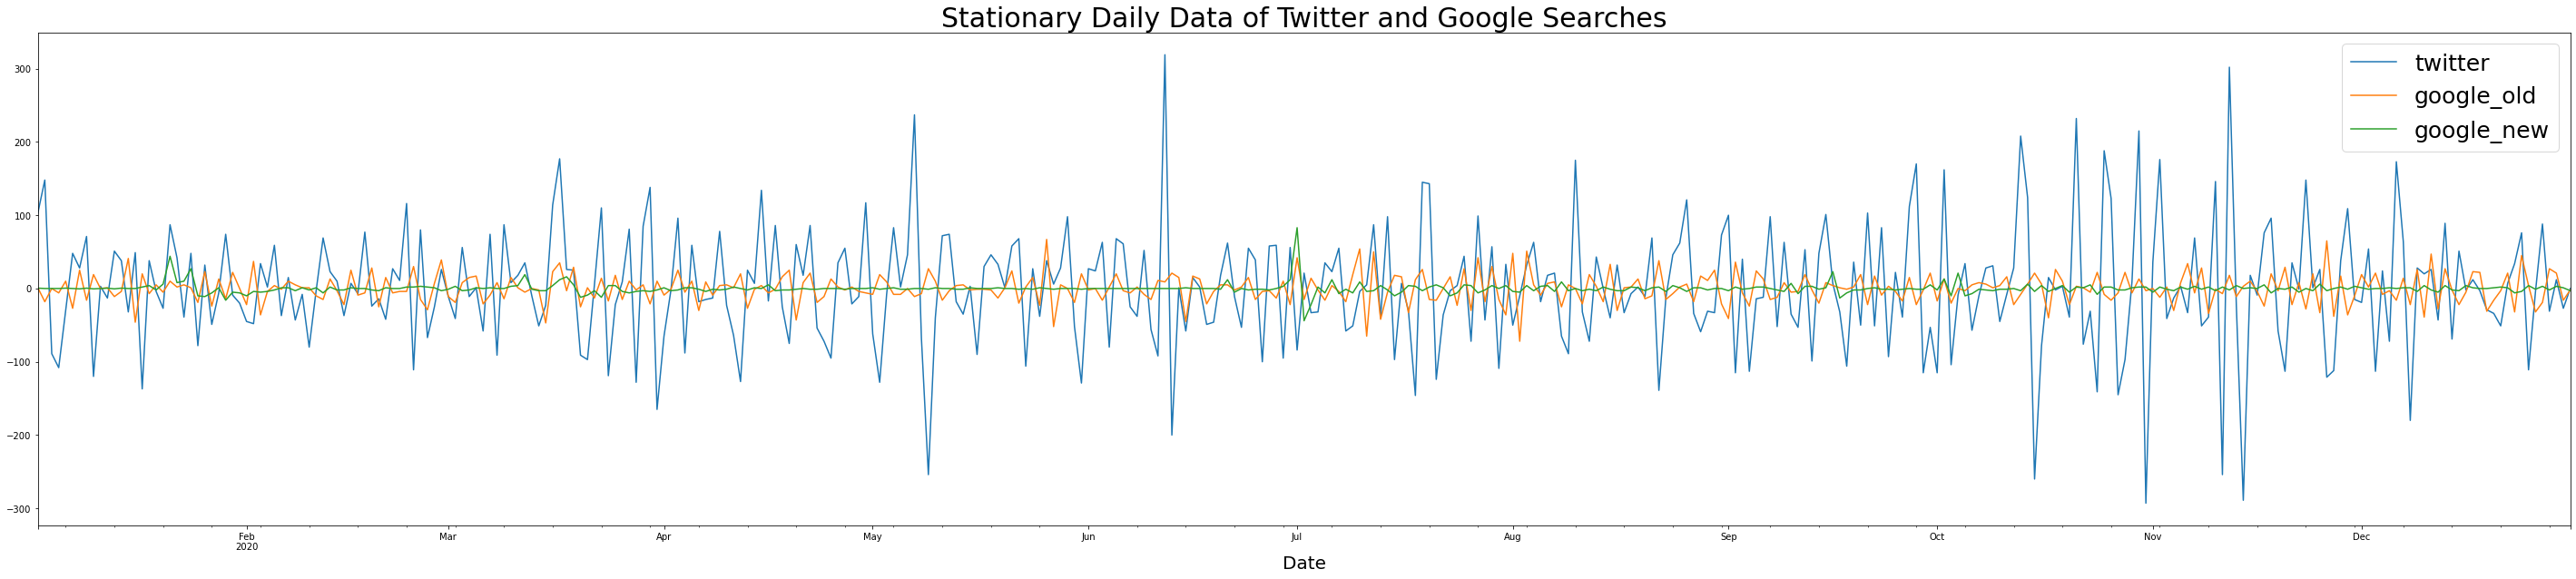

In [6]:
daily_data.plot(figsize=(50, 10))
plt.xlabel('Date', fontsize=20)
plt.title('Stationary Daily Data of Twitter and Google Searches', fontsize=30)
plt.legend(fontsize=25)

### Vector autoregressive (VAR) modelling

In [7]:
model = VAR(daily_data)
optimal_order = model.select_order()
model_fitted = model.fit(maxlags=optimal_order.aic, ic='aic')
resid = model_fitted.resid[optimal_order.aic:]

/Users/itsyuzhou/opt/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


- AIC = Akaike Information Criterion
- BIC = Bayesian Information Criterion
- FPE = Final Prediction Error
- HQIC = Hannan-Quinn Criterion

### Granger Causality Test on VAR (twitter --> Google old)

In [8]:
results = grangercausalitytests(resid[['twitter', 'google_old']], maxlag=15, verbose=False)
p_values_tgo = []

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")
    p_values_tgo.append([lag, test_results[0]['params_ftest'][1]])

print('twitter --> old google: ',p_values_tgo)

Lag 1
	F-Statistic: 0.0263, p-value: 0.8712
Lag 2
	F-Statistic: 0.0664, p-value: 0.9357
Lag 3
	F-Statistic: 0.2144, p-value: 0.8864
Lag 4
	F-Statistic: 0.2806, p-value: 0.8904
Lag 5
	F-Statistic: 0.2317, p-value: 0.9485
Lag 6
	F-Statistic: 0.1905, p-value: 0.9794
Lag 7
	F-Statistic: 0.1750, p-value: 0.9902
Lag 8
	F-Statistic: 0.4212, p-value: 0.9081
Lag 9
	F-Statistic: 0.4278, p-value: 0.9199
Lag 10
	F-Statistic: 0.5129, p-value: 0.8808
Lag 11
	F-Statistic: 0.5252, p-value: 0.8860
Lag 12
	F-Statistic: 0.5010, p-value: 0.9136
Lag 13
	F-Statistic: 0.4692, p-value: 0.9407
Lag 14
	F-Statistic: 0.4525, p-value: 0.9556
Lag 15
	F-Statistic: 0.4249, p-value: 0.9713
twitter --> old google:  [[1, 0.8712466716531319], [2, 0.9357413844274216], [3, 0.8863868816156177], [4, 0.8904437598958973], [5, 0.9484970920963491], [6, 0.9793817241127223], [7, 0.990173278120028], [8, 0.908079042828093], [9, 0.919867176858941], [10, 0.8808264750128416], [11, 0.886005245591002], [12, 0.9135981954841933], [13, 0.94

### Plot the p-values on different lags

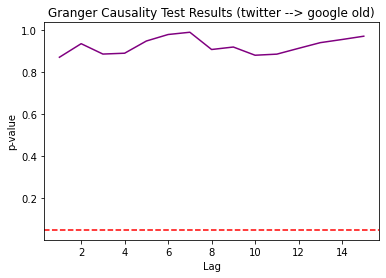

In [9]:
p_values = [test_results[0]['params_ftest'][1] for lag, test_results in results.items()]

fig, ax = plt.subplots()
ax.plot(range(1, len(p_values)+1), p_values, color='purple')
ax.axhline(y=0.05, color='red', linestyle='--')
ax.set_xlabel('Lag')
ax.set_ylabel('p-value')
ax.set_title('Granger Causality Test Results (twitter --> google old)')
plt.show()

### Granger Causality Test on VAR (twitter --> Google new)

In [10]:
results = grangercausalitytests(resid[['twitter', 'google_new']], maxlag=15, verbose=False)
p_values_tgn = []

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")
    p_values_tgn.append([lag, test_results[0]['params_ftest'][1]])

print('twitter --> new google: ', p_values_tgn)

Lag 1
	F-Statistic: 0.0281, p-value: 0.8670
Lag 2
	F-Statistic: 0.0196, p-value: 0.9806
Lag 3
	F-Statistic: 0.0430, p-value: 0.9881
Lag 4
	F-Statistic: 0.0406, p-value: 0.9969
Lag 5
	F-Statistic: 0.0346, p-value: 0.9994
Lag 6
	F-Statistic: 0.0400, p-value: 0.9997
Lag 7
	F-Statistic: 0.3470, p-value: 0.9317
Lag 8
	F-Statistic: 0.3363, p-value: 0.9515
Lag 9
	F-Statistic: 0.3034, p-value: 0.9734
Lag 10
	F-Statistic: 0.3016, p-value: 0.9805
Lag 11
	F-Statistic: 0.4023, p-value: 0.9546
Lag 12
	F-Statistic: 0.3788, p-value: 0.9704
Lag 13
	F-Statistic: 0.4342, p-value: 0.9566
Lag 14
	F-Statistic: 0.4550, p-value: 0.9546
Lag 15
	F-Statistic: 0.4739, p-value: 0.9526
twitter --> new google:  [[1, 0.8670409778321864], [2, 0.9806202339790399], [3, 0.9881157226666332], [4, 0.9968587878067848], [5, 0.9993694142272179], [6, 0.999733292948166], [7, 0.9316678880873285], [8, 0.9515309611352408], [9, 0.9734313123923477], [10, 0.980498168525182], [11, 0.9546154172564869], [12, 0.9704444101899965], [13, 0.

### Plot the p-values on different lags

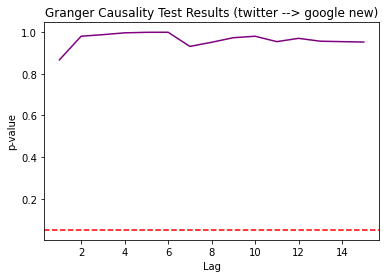

In [11]:
p_values = [test_results[0]['params_ftest'][1] for lag, test_results in results.items()]

fig, ax = plt.subplots()
ax.plot(range(1, len(p_values)+1), p_values, color='purple')
ax.axhline(y=0.05, color='red', linestyle='--')
ax.set_xlabel('Lag')
ax.set_ylabel('p-value')
ax.set_title('Granger Causality Test Results (twitter --> google new)')
plt.show()

### Granger Causality Test on VAR (Google old --> twitter)

In [12]:
results = grangercausalitytests(resid[['google_old', 'twitter']], maxlag=15, verbose=False)
p_values_got = []

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")
    p_values_got.append([lag, test_results[0]['params_ftest'][1]])

print('old google --> twitter: ', p_values_got)

Lag 1
	F-Statistic: 0.1077, p-value: 0.7429
Lag 2
	F-Statistic: 0.1038, p-value: 0.9015
Lag 3
	F-Statistic: 0.1258, p-value: 0.9448
Lag 4
	F-Statistic: 0.0928, p-value: 0.9847
Lag 5
	F-Statistic: 0.0860, p-value: 0.9944
Lag 6
	F-Statistic: 0.0667, p-value: 0.9988
Lag 7
	F-Statistic: 0.1072, p-value: 0.9979
Lag 8
	F-Statistic: 0.1040, p-value: 0.9991
Lag 9
	F-Statistic: 0.0965, p-value: 0.9997
Lag 10
	F-Statistic: 0.0730, p-value: 1.0000
Lag 11
	F-Statistic: 0.0750, p-value: 1.0000
Lag 12
	F-Statistic: 0.0996, p-value: 1.0000
Lag 13
	F-Statistic: 0.0997, p-value: 1.0000
Lag 14
	F-Statistic: 0.1328, p-value: 0.9999
Lag 15
	F-Statistic: 0.1206, p-value: 1.0000
old google --> twitter:  [[1, 0.7429325082216192], [2, 0.9014536116871958], [3, 0.9447831086651469], [4, 0.9847077437449178], [5, 0.9944196923075359], [6, 0.9988345576318711], [7, 0.9978727363215728], [8, 0.9990778881958852], [9, 0.9996735849836704], [10, 0.9999579287628175], [11, 0.9999799543443617], [12, 0.9999589512514743], [13, 

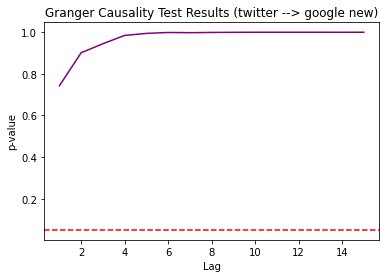

In [13]:
p_values = [test_results[0]['params_ftest'][1] for lag, test_results in results.items()]

fig, ax = plt.subplots()
ax.plot(range(1, len(p_values)+1), p_values, color='purple')
ax.axhline(y=0.05, color='red', linestyle='--')
ax.set_xlabel('Lag')
ax.set_ylabel('p-value')
ax.set_title('Granger Causality Test Results (twitter --> google new)')
plt.show()

In [14]:
results = grangercausalitytests(resid[['google_new', 'twitter']], maxlag=15, verbose=False)
p_values_gnt = []

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")
    p_values_gnt.append([lag, test_results[0]['params_ftest'][1]])

print('new google --> twitter: ', p_values_gnt)

Lag 1
	F-Statistic: 0.0323, p-value: 0.8575
Lag 2
	F-Statistic: 0.0204, p-value: 0.9798
Lag 3
	F-Statistic: 0.0575, p-value: 0.9818
Lag 4
	F-Statistic: 0.0657, p-value: 0.9920
Lag 5
	F-Statistic: 0.0609, p-value: 0.9975
Lag 6
	F-Statistic: 0.0749, p-value: 0.9984
Lag 7
	F-Statistic: 0.1198, p-value: 0.9970
Lag 8
	F-Statistic: 0.3836, p-value: 0.9291
Lag 9
	F-Statistic: 0.4209, p-value: 0.9237
Lag 10
	F-Statistic: 0.5100, p-value: 0.8828
Lag 11
	F-Statistic: 0.8209, p-value: 0.6192
Lag 12
	F-Statistic: 0.8475, p-value: 0.6013
Lag 13
	F-Statistic: 0.7790, p-value: 0.6824
Lag 14
	F-Statistic: 0.8171, p-value: 0.6504
Lag 15
	F-Statistic: 0.8072, p-value: 0.6696
new google --> twitter:  [[1, 0.8574663661622131], [2, 0.9798136587578367], [3, 0.9818486665163948], [4, 0.9920418360927178], [5, 0.9975318843651148], [6, 0.9983795225483733], [7, 0.9969732877035498], [8, 0.9290559425304078], [9, 0.9236793748369208], [10, 0.8828421873671052], [11, 0.6191879567234164], [12, 0.6013413578675939], [13, 

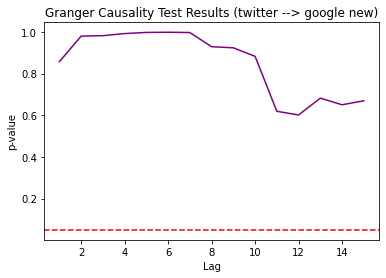

In [15]:
p_values = [test_results[0]['params_ftest'][1] for lag, test_results in results.items()]

fig, ax = plt.subplots()
ax.plot(range(1, len(p_values)+1), p_values, color='purple')
ax.axhline(y=0.05, color='red', linestyle='--')
ax.set_xlabel('Lag')
ax.set_ylabel('p-value')
ax.set_title('Granger Causality Test Results (twitter --> google new)')
plt.show()

### Visualize the table for p-values for daily twitter and Google search Granger Causality

In [16]:
def format_pval(val):
    return f"{val:.3f}*" if val < 0.05 else f"{val:.3f}"

data = {'Causality Test': ['Daily Sinophobic Tweets → Daily Google Search on Old Sinophobic Terms',                           
                           'Daily Sinophobic Tweets → Daily Google Search on New Sinophobic Terms', 
                           'Daily Google Search on Old Sinophobic Terms → Daily Sinophobic Tweets', 
                           'Daily Google Search on New Sinophobic Terms → Daily Sinophobic Tweets'],
        'p-value at Lag 1': [p_values_tgo[0][1], p_values_tgn[0][1], p_values_got[0][1], p_values_gnt[0][1]],
        'p-value at Lag 2': [p_values_tgo[1][1], p_values_tgn[1][1], p_values_got[1][1], p_values_gnt[1][1]],
        'p-value at Lag 3': [p_values_tgo[2][1], p_values_tgn[2][1], p_values_got[2][1], p_values_gnt[2][1]],
        'p-value at Lag 4': [p_values_tgo[3][1], p_values_tgn[3][1], p_values_got[3][1], p_values_gnt[3][1]],
        'p-value at Lag 5': [p_values_tgo[4][1], p_values_tgn[4][1], p_values_got[4][1], p_values_gnt[4][1]],
        'p-value at Lag 6': [p_values_tgo[5][1], p_values_tgn[5][1], p_values_got[5][1], p_values_gnt[5][1]],
        'p-value at Lag 7': [p_values_tgo[6][1], p_values_tgn[6][1], p_values_got[6][1], p_values_gnt[6][1]],
        'p-value at Lag 8': [p_values_tgo[7][1], p_values_tgn[7][1], p_values_got[7][1], p_values_gnt[7][1]],
        'p-value at Lag 9': [p_values_tgo[8][1], p_values_tgn[8][1], p_values_got[8][1], p_values_gnt[8][1]],
        'p-value at Lag 10': [p_values_tgo[9][1], p_values_tgn[9][1], p_values_got[9][1], p_values_gnt[9][1]],
        'p-value at Lag 11': [p_values_tgo[10][1], p_values_tgn[10][1], p_values_got[10][1], p_values_gnt[10][1]],
        'p-value at Lag 12': [p_values_tgo[11][1], p_values_tgn[11][1], p_values_got[11][1], p_values_gnt[11][1]],
        'p-value at Lag 13': [p_values_tgo[12][1], p_values_tgn[12][1], p_values_got[12][1], p_values_gnt[12][1]],
        'p-value at Lag 14': [p_values_tgo[13][1], p_values_tgn[13][1], p_values_got[13][1], p_values_gnt[13][1]],
        'p-value at Lag 15': [p_values_tgo[14][1], p_values_tgn[14][1], p_values_got[14][1], p_values_gnt[14][1]]
        }

df = pd.DataFrame(data)
df = df.set_index('Causality Test')
df = df.applymap(format_pval)
df.to_csv('/Users/itsyuzhou/Spring2023/MACS30200/replication-materials-yuzhouw313/daily_pval.csv')

In [17]:
df

,p-value at Lag 1,p-value at Lag 2,p-value at Lag 3,p-value at Lag 4,p-value at Lag 5,p-value at Lag 6,p-value at Lag 7,p-value at Lag 8,p-value at Lag 9,p-value at Lag 10,p-value at Lag 11,p-value at Lag 12,p-value at Lag 13,p-value at Lag 14,p-value at Lag 15
Causality Test,,,,,,,,,,,,,,,
Daily Sinophobic Tweets → Daily Google Search on Old Sinophobic Terms,0.871,0.936,0.886,0.890,0.948,0.979,0.990,0.908,0.920,0.881,0.886,0.914,0.941,0.956,0.971
Daily Sinophobic Tweets → Daily Google Search on New Sinophobic Terms,0.867,0.981,0.988,0.997,0.999,1.000,0.932,0.952,0.973,0.980,0.955,0.970,0.957,0.955,0.953
Daily Google Search on Old Sinophobic Terms → Daily Sinophobic Tweets,0.743,0.901,0.945,0.985,0.994,0.999,0.998,0.999,1.000,1.000,1.000,1.000,1.000,1.000,1.000
Daily Google Search on New Sinophobic Terms → Daily Sinophobic Tweets,0.857,0.980,0.982,0.992,0.998,0.998,0.997,0.929,0.924,0.883,0.619,0.601,0.682,0.650,0.670


## Granger Causality for Weekly Twitter and Google Search Time Series

In [18]:
weekly_data = pd.concat([twitter_w, google_w_old, google_w_new, crime_w], axis=1)
weekly_data = weekly_data.set_axis(['twitter', 'google_old', 'google_new', 'crime'], axis=1)
weekly_data

,twitter,google_old,google_new,crime
2020-01-05,2024.0,47.800000,0.400000,2
2020-01-12,1997.0,39.857143,0.785714,4
2020-01-19,1826.0,43.857143,2.642857,3
2020-01-26,2066.0,52.142857,67.285714,2
2020-02-02,1846.0,51.714286,53.571429,10
2020-02-09,1559.0,43.714286,23.428571,3
2020-02-16,1580.0,39.142857,16.428571,2
2020-02-23,1767.0,38.714286,11.285714,3
2020-03-01,1786.0,43.000000,16.428571,4
2020-03-08,1678.0,50.857143,15.857143,3


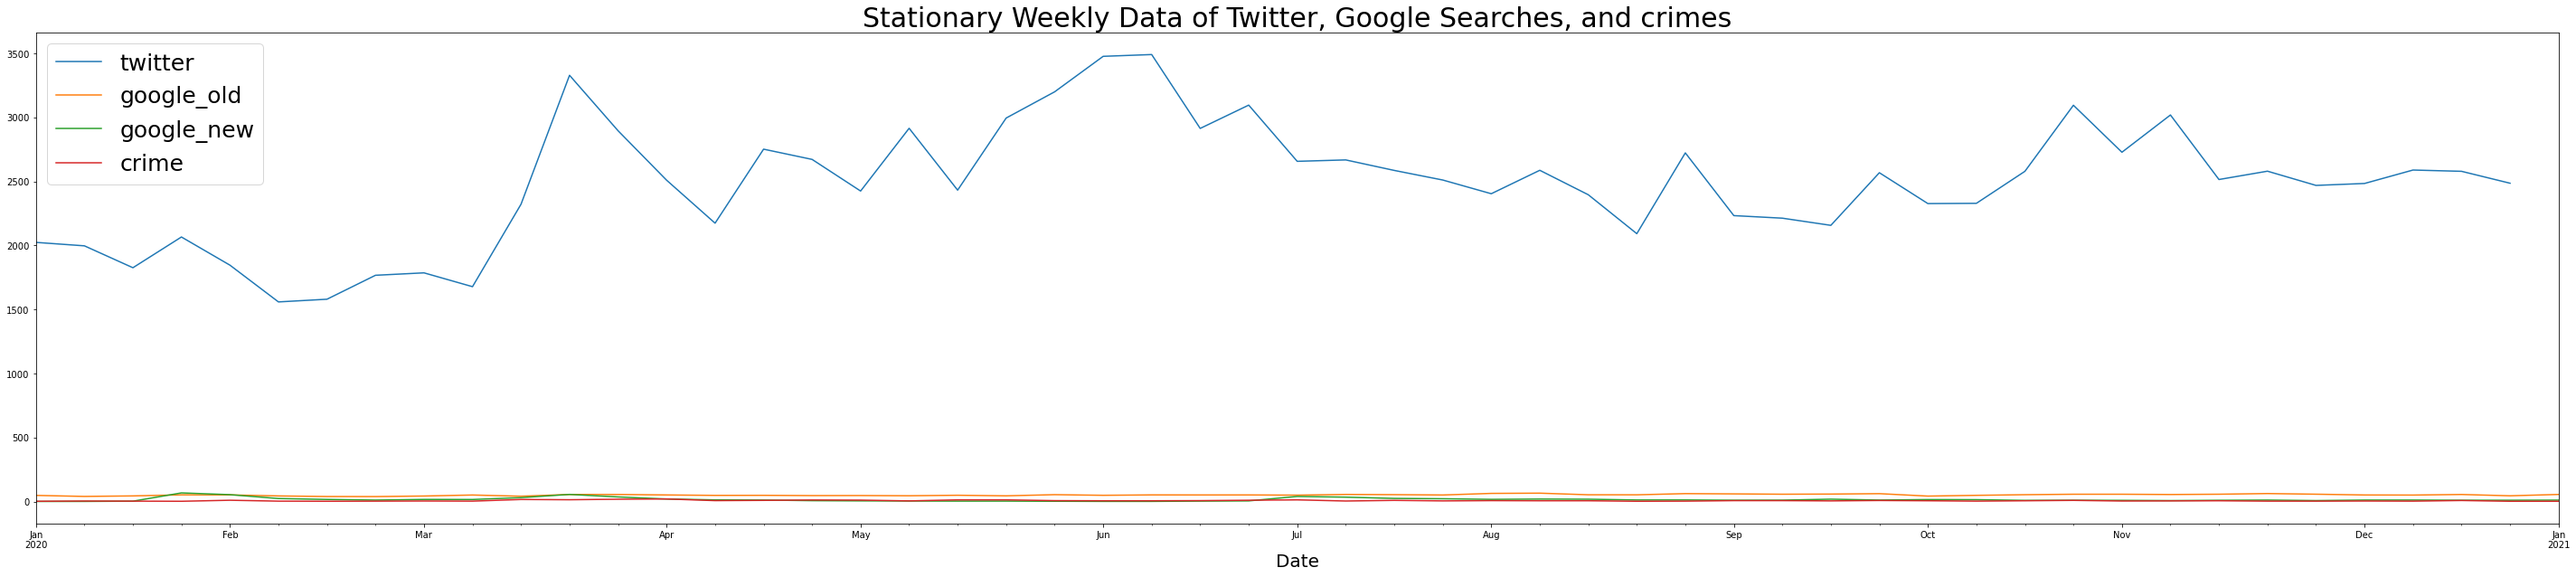

In [19]:
weekly_data.plot(figsize=(50, 10))
plt.xlabel('Date', fontsize=20)
plt.title('Stationary Weekly Data of Twitter, Google Searches, and crimes', fontsize=30)
plt.legend(fontsize=25)

In [20]:
if weekly_data.isna().any().any():
    print("The DataFrame contains NaN values.")
else:
    print("The DataFrame does not contain NaN values.")

The DataFrame contains NaN values.


In [21]:
weekly_data = weekly_data.fillna(weekly_data.mean())

In [22]:
model2 = VAR(weekly_data)
optimal_order2 = model2.select_order()
model_fitted2 = model2.fit(maxlags=optimal_order2.aic, ic='aic')
resid2 = model_fitted2.resid[optimal_order2.aic:]

### Granger Causality Test on VAR (twitter and google)

In [23]:
results = grangercausalitytests(resid2[['twitter', 'google_old']], maxlag=8, verbose=False)
tgo_pvals = []

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")
    tgo_pvals.append(test_results[0]['params_ftest'][1])

Lag 1
	F-Statistic: 1.2333, p-value: 0.2753
Lag 2
	F-Statistic: 1.9413, p-value: 0.1624
Lag 3
	F-Statistic: 2.2932, p-value: 0.1025
Lag 4
	F-Statistic: 0.8990, p-value: 0.4814
Lag 5
	F-Statistic: 0.6662, p-value: 0.6536
Lag 6
	F-Statistic: 0.6787, p-value: 0.6691
Lag 7
	F-Statistic: 0.3006, p-value: 0.9412
Lag 8
	F-Statistic: 0.2265, p-value: 0.9769


In [24]:
results = grangercausalitytests(resid2[['twitter', 'google_new']], maxlag=8, verbose=False)
tgn_pvals = []

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")
    tgn_pvals.append(test_results[0]['params_ftest'][1])

Lag 1
	F-Statistic: 0.0055, p-value: 0.9411
Lag 2
	F-Statistic: 0.0349, p-value: 0.9657
Lag 3
	F-Statistic: 0.0290, p-value: 0.9932
Lag 4
	F-Statistic: 0.2539, p-value: 0.9041
Lag 5
	F-Statistic: 0.4121, p-value: 0.8345
Lag 6
	F-Statistic: 0.6130, p-value: 0.7170
Lag 7
	F-Statistic: 1.6572, p-value: 0.2048
Lag 8
	F-Statistic: 0.9371, p-value: 0.5274


In [25]:
results = grangercausalitytests(resid2[[ 'google_old', 'twitter']], maxlag=8, verbose=False)
got_pvals = []

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")
    got_pvals.append(test_results[0]['params_ftest'][1])

Lag 1
	F-Statistic: 0.7303, p-value: 0.3994
Lag 2
	F-Statistic: 1.5192, p-value: 0.2364
Lag 3
	F-Statistic: 1.5199, p-value: 0.2338
Lag 4
	F-Statistic: 1.4762, p-value: 0.2434
Lag 5
	F-Statistic: 1.7133, p-value: 0.1799
Lag 6
	F-Statistic: 2.4295, p-value: 0.0730
Lag 7
	F-Statistic: 1.7980, p-value: 0.1713
Lag 8
	F-Statistic: 1.0683, p-value: 0.4518


In [26]:
results = grangercausalitytests(resid2[['google_new', 'twitter']], maxlag=8, verbose=False)
gnt_pvals = []

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")
    gnt_pvals.append(test_results[0]['params_ftest'][1])

Lag 1
	F-Statistic: 0.5726, p-value: 0.4549
Lag 2
	F-Statistic: 0.3204, p-value: 0.7285
Lag 3
	F-Statistic: 1.4510, p-value: 0.2518
Lag 4
	F-Statistic: 1.0822, p-value: 0.3894
Lag 5
	F-Statistic: 0.8525, p-value: 0.5301
Lag 6
	F-Statistic: 0.6837, p-value: 0.6655
Lag 7
	F-Statistic: 0.5434, p-value: 0.7874
Lag 8
	F-Statistic: 0.6215, p-value: 0.7439


### Granger Causality Test on VAR (twitter and crime)

In [27]:
results = grangercausalitytests(resid2[['twitter', 'crime']], maxlag=8, verbose=False)
tc_pvals = []

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")
    tc_pvals.append(test_results[0]['params_ftest'][1])

Lag 1
	F-Statistic: 0.1985, p-value: 0.6590
Lag 2
	F-Statistic: 0.2769, p-value: 0.7602
Lag 3
	F-Statistic: 0.7351, p-value: 0.5409
Lag 4
	F-Statistic: 1.4843, p-value: 0.2410
Lag 5
	F-Statistic: 1.1790, p-value: 0.3559
Lag 6
	F-Statistic: 0.7474, p-value: 0.6202
Lag 7
	F-Statistic: 0.6382, p-value: 0.7178
Lag 8
	F-Statistic: 0.4521, p-value: 0.8635


In [28]:
results = grangercausalitytests(resid2[['crime', 'twitter']], maxlag=8, verbose=False)
ct_pvals = []

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")
    ct_pvals.append(test_results[0]['params_ftest'][1])

Lag 1
	F-Statistic: 0.1284, p-value: 0.7226
Lag 2
	F-Statistic: 2.6664, p-value: 0.0871
Lag 3
	F-Statistic: 1.5302, p-value: 0.2312
Lag 4
	F-Statistic: 3.0472, p-value: 0.0386
Lag 5
	F-Statistic: 2.3415, p-value: 0.0813
Lag 6
	F-Statistic: 1.4636, p-value: 0.2523
Lag 7
	F-Statistic: 1.2833, p-value: 0.3307
Lag 8
	F-Statistic: 0.8960, p-value: 0.5531


### Granger Causality Test on VAR (Google search and crime)

In [29]:
results = grangercausalitytests(resid2[['google_old', 'crime']], maxlag=8, verbose=False)
goc_pvals = []

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")
    goc_pvals.append(test_results[0]['params_ftest'][1])

Lag 1
	F-Statistic: 0.0024, p-value: 0.9614
Lag 2
	F-Statistic: 0.5476, p-value: 0.5844
Lag 3
	F-Statistic: 0.8980, p-value: 0.4560
Lag 4
	F-Statistic: 0.5566, p-value: 0.6964
Lag 5
	F-Statistic: 0.3872, p-value: 0.8514
Lag 6
	F-Statistic: 0.3164, p-value: 0.9190
Lag 7
	F-Statistic: 0.6067, p-value: 0.7410
Lag 8
	F-Statistic: 0.6319, p-value: 0.7363


In [30]:
results = grangercausalitytests(resid2[['google_new', 'crime']], maxlag=8, verbose=False)
gnc_pvals = []

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")
    gnc_pvals.append(test_results[0]['params_ftest'][1])

Lag 1
	F-Statistic: 0.0502, p-value: 0.8241
Lag 2
	F-Statistic: 0.1737, p-value: 0.8414
Lag 3
	F-Statistic: 0.4194, p-value: 0.7407
Lag 4
	F-Statistic: 0.2757, p-value: 0.8905
Lag 5
	F-Statistic: 0.0739, p-value: 0.9955
Lag 6
	F-Statistic: 0.1461, p-value: 0.9872
Lag 7
	F-Statistic: 0.8384, p-value: 0.5751
Lag 8
	F-Statistic: 1.0061, p-value: 0.4864


In [31]:
results = grangercausalitytests(resid2[['crime', 'google_old']], maxlag=8, verbose=False)
cgo_pvals = []

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")
    cgo_pvals.append(test_results[0]['params_ftest'][1])

Lag 1
	F-Statistic: 4.0423, p-value: 0.0531
Lag 2
	F-Statistic: 3.4883, p-value: 0.0444
Lag 3
	F-Statistic: 2.2750, p-value: 0.1045
Lag 4
	F-Statistic: 1.8782, p-value: 0.1501
Lag 5
	F-Statistic: 1.2579, p-value: 0.3222
Lag 6
	F-Statistic: 0.9185, p-value: 0.5071
Lag 7
	F-Statistic: 0.6810, p-value: 0.6864
Lag 8
	F-Statistic: 0.4240, p-value: 0.8816


In [32]:
results = grangercausalitytests(resid2[['crime', 'google_new']], maxlag=8, verbose=False)
cgn_pvals = []

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")
    cgn_pvals.append(test_results[0]['params_ftest'][1])

Lag 1
	F-Statistic: 1.6948, p-value: 0.2026
Lag 2
	F-Statistic: 1.1158, p-value: 0.3418
Lag 3
	F-Statistic: 0.9437, p-value: 0.4345
Lag 4
	F-Statistic: 0.7477, p-value: 0.5700
Lag 5
	F-Statistic: 0.7428, p-value: 0.6011
Lag 6
	F-Statistic: 0.5938, p-value: 0.7310
Lag 7
	F-Statistic: 2.0384, p-value: 0.1269
Lag 8
	F-Statistic: 2.3599, p-value: 0.1018


### Visualize p-values of Granger Causality Test on Weekly Time Series

In [33]:
def format_pval(val):
    return f"{val:.3f}*" if val < 0.05 else f"{val:.3f}"

data = {'Causality Test': ['Weekly Sinophobic Tweets → Weekly Google Search on Old Sinophobic Terms',                           
                           'Weekly Sinophobic Tweets → Weekly Google Search on New Sinophobic Terms', 
                           'Weekly Google Search on Old Sinophobic Terms → Weekly Sinophobic Tweets', 
                           'Weekly Google Search on New Sinophobic Terms → Weekly Sinophobic Tweets',
                           'Weekly Sinophobic Tweets → Weekly Anti-Asian Hate Crimes',
                           'Weekly Anti-Asian Hate Crimes → Weekly Sinophobic Tweets',
                           'Weekly Google Search on Old Sinophobic Terms → Weekly Anti-Asian Hate Crimes',
                           'Weekly Google Search on New Sinophobic Terms → Weekly Anti-Asian Hate Crimes',
                           'Weekly Anti-Asian Hate Crimes → Weekly Google Search on Old Sinophobic Terms',
                           'Weekly Anti-Asian Hate Crimes → Weekly Google Search on New Sinophobic Terms'
                           ],
        'p-value at Lag 1': [tgo_pvals[0], tgn_pvals[0], got_pvals[0], gnt_pvals[0], tc_pvals[0], ct_pvals[0], goc_pvals[0], gnc_pvals[0], cgo_pvals[0], cgn_pvals[0]],
        'p-value at Lag 2': [tgo_pvals[1], tgn_pvals[1], got_pvals[1], gnt_pvals[1], tc_pvals[1], ct_pvals[1], goc_pvals[1], gnc_pvals[1], cgo_pvals[1], cgn_pvals[1]],
        'p-value at Lag 3': [tgo_pvals[2], tgn_pvals[2], got_pvals[2], gnt_pvals[2], tc_pvals[2], ct_pvals[2], goc_pvals[2], gnc_pvals[2], cgo_pvals[2], cgn_pvals[2]],
        'p-value at Lag 4': [tgo_pvals[3], tgn_pvals[3], got_pvals[3], gnt_pvals[3], tc_pvals[3], ct_pvals[3], goc_pvals[3], gnc_pvals[3], cgo_pvals[3], cgn_pvals[3]],
        'p-value at Lag 5': [tgo_pvals[4], tgn_pvals[4], got_pvals[4], gnt_pvals[4], tc_pvals[4], ct_pvals[4], goc_pvals[4], gnc_pvals[4], cgo_pvals[4], cgn_pvals[4]],
        'p-value at Lag 6': [tgo_pvals[5], tgn_pvals[5], got_pvals[5], gnt_pvals[5], tc_pvals[5], ct_pvals[5], goc_pvals[5], gnc_pvals[5], cgo_pvals[5], cgn_pvals[5]],
        'p-value at Lag 7': [tgo_pvals[6], tgn_pvals[6], got_pvals[6], gnt_pvals[6], tc_pvals[6], ct_pvals[6], goc_pvals[6], gnc_pvals[6], cgo_pvals[6], cgn_pvals[6]],
        'p-value at Lag 8': [tgo_pvals[7], tgn_pvals[7], got_pvals[7], gnt_pvals[7], tc_pvals[7], ct_pvals[7], goc_pvals[7], gnc_pvals[7], cgo_pvals[7], cgn_pvals[7]]
        }
df = pd.DataFrame(data)
df = df.set_index('Causality Test')
df = df.applymap(format_pval)
df.to_csv('/Users/itsyuzhou/Spring2023/MACS30200/replication-materials-yuzhouw313/weekly_pval.csv', index=True)


In [34]:
df

,p-value at Lag 1,p-value at Lag 2,p-value at Lag 3,p-value at Lag 4,p-value at Lag 5,p-value at Lag 6,p-value at Lag 7,p-value at Lag 8
Causality Test,,,,,,,,
Weekly Sinophobic Tweets → Weekly Google Search on Old Sinophobic Terms,0.275,0.162,0.103,0.481,0.654,0.669,0.941,0.977
Weekly Sinophobic Tweets → Weekly Google Search on New Sinophobic Terms,0.941,0.966,0.993,0.904,0.834,0.717,0.205,0.527
Weekly Google Search on Old Sinophobic Terms → Weekly Sinophobic Tweets,0.399,0.236,0.234,0.243,0.180,0.073,0.171,0.452
Weekly Google Search on New Sinophobic Terms → Weekly Sinophobic Tweets,0.455,0.729,0.252,0.389,0.530,0.665,0.787,0.744
Weekly Sinophobic Tweets → Weekly Anti-Asian Hate Crimes,0.659,0.760,0.541,0.241,0.356,0.620,0.718,0.863
Weekly Anti-Asian Hate Crimes → Weekly Sinophobic Tweets,0.723,0.087,0.231,0.039*,0.081,0.252,0.331,0.553
Weekly Google Search on Old Sinophobic Terms → Weekly Anti-Asian Hate Crimes,0.961,0.584,0.456,0.696,0.851,0.919,0.741,0.736
Weekly Google Search on New Sinophobic Terms → Weekly Anti-Asian Hate Crimes,0.824,0.841,0.741,0.891,0.996,0.987,0.575,0.486
Weekly Anti-Asian Hate Crimes → Weekly Google Search on Old Sinophobic Terms,0.053,0.044*,0.105,0.150,0.322,0.507,0.686,0.882


In [35]:
results = grangercausalitytests(weekly_data[['twitter', 'google_old']], maxlag=8, verbose=False)

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")

Lag 1
	F-Statistic: 0.7209, p-value: 0.4000
Lag 2
	F-Statistic: 0.8806, p-value: 0.4214
Lag 3
	F-Statistic: 0.7065, p-value: 0.5534
Lag 4
	F-Statistic: 0.6727, p-value: 0.6148
Lag 5
	F-Statistic: 1.5589, p-value: 0.1958
Lag 6
	F-Statistic: 2.9916, p-value: 0.0186
Lag 7
	F-Statistic: 3.4914, p-value: 0.0071
Lag 8
	F-Statistic: 2.9328, p-value: 0.0164


In [36]:
results = grangercausalitytests(weekly_data[['twitter', 'google_new']], maxlag=8, verbose=False)

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")

Lag 1
	F-Statistic: 2.6630, p-value: 0.1091
Lag 2
	F-Statistic: 2.3059, p-value: 0.1111
Lag 3
	F-Statistic: 2.0340, p-value: 0.1233
Lag 4
	F-Statistic: 1.4603, p-value: 0.2323
Lag 5
	F-Statistic: 1.5182, p-value: 0.2079
Lag 6
	F-Statistic: 1.1588, p-value: 0.3509
Lag 7
	F-Statistic: 1.7332, p-value: 0.1376
Lag 8
	F-Statistic: 1.3608, p-value: 0.2561


In [37]:
results = grangercausalitytests(weekly_data[['google_old', 'twitter']], maxlag=8, verbose=False)

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")

Lag 1
	F-Statistic: 1.7354, p-value: 0.1938
Lag 2
	F-Statistic: 0.6185, p-value: 0.5432
Lag 3
	F-Statistic: 0.5040, p-value: 0.6816
Lag 4
	F-Statistic: 0.5316, p-value: 0.7132
Lag 5
	F-Statistic: 0.4547, p-value: 0.8072
Lag 6
	F-Statistic: 0.5849, p-value: 0.7398
Lag 7
	F-Statistic: 0.2357, p-value: 0.9731
Lag 8
	F-Statistic: 0.5378, p-value: 0.8179


In [38]:
results = grangercausalitytests(weekly_data[['google_new', 'twitter']], maxlag=8, verbose=False)

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")

Lag 1
	F-Statistic: 2.0941, p-value: 0.1542
Lag 2
	F-Statistic: 2.5740, p-value: 0.0872
Lag 3
	F-Statistic: 2.3422, p-value: 0.0865
Lag 4
	F-Statistic: 1.1568, p-value: 0.3442
Lag 5
	F-Statistic: 1.1637, p-value: 0.3453
Lag 6
	F-Statistic: 1.3173, p-value: 0.2763
Lag 7
	F-Statistic: 1.0662, p-value: 0.4079
Lag 8
	F-Statistic: 1.0538, p-value: 0.4218


In [39]:
results = grangercausalitytests(weekly_data[['twitter', 'crime']], maxlag=8, verbose=False)

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")

Lag 1
	F-Statistic: 0.5021, p-value: 0.4819
Lag 2
	F-Statistic: 0.2447, p-value: 0.7840
Lag 3
	F-Statistic: 0.2840, p-value: 0.8366
Lag 4
	F-Statistic: 0.3001, p-value: 0.8761
Lag 5
	F-Statistic: 0.4891, p-value: 0.7822
Lag 6
	F-Statistic: 0.7659, p-value: 0.6018
Lag 7
	F-Statistic: 0.5469, p-value: 0.7922
Lag 8
	F-Statistic: 0.7049, p-value: 0.6847


In [40]:
results = grangercausalitytests(weekly_data[['crime', 'twitter']], maxlag=8, verbose=False)

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")

Lag 1
	F-Statistic: 1.8222, p-value: 0.1833
Lag 2
	F-Statistic: 2.4864, p-value: 0.0943
Lag 3
	F-Statistic: 2.5280, p-value: 0.0699
Lag 4
	F-Statistic: 1.7299, p-value: 0.1624
Lag 5
	F-Statistic: 1.3725, p-value: 0.2569
Lag 6
	F-Statistic: 1.5418, p-value: 0.1945
Lag 7
	F-Statistic: 1.3175, p-value: 0.2752
Lag 8
	F-Statistic: 1.2004, p-value: 0.3343


In [41]:
results = grangercausalitytests(weekly_data[['google_old', 'crime']], maxlag=8, verbose=False)

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")

Lag 1
	F-Statistic: 0.1408, p-value: 0.7091
Lag 2
	F-Statistic: 0.2927, p-value: 0.7476
Lag 3
	F-Statistic: 0.7104, p-value: 0.5511
Lag 4
	F-Statistic: 0.7844, p-value: 0.5421
Lag 5
	F-Statistic: 0.9523, p-value: 0.4593
Lag 6
	F-Statistic: 0.6194, p-value: 0.7133
Lag 7
	F-Statistic: 1.1153, p-value: 0.3786
Lag 8
	F-Statistic: 0.7212, p-value: 0.6714


In [42]:
results = grangercausalitytests(weekly_data[['google_new', 'crime']], maxlag=8, verbose=False)

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")

Lag 1
	F-Statistic: 0.0189, p-value: 0.8912
Lag 2
	F-Statistic: 0.9103, p-value: 0.4095
Lag 3
	F-Statistic: 1.4487, p-value: 0.2419
Lag 4
	F-Statistic: 2.0377, p-value: 0.1074
Lag 5
	F-Statistic: 1.5036, p-value: 0.2124
Lag 6
	F-Statistic: 1.5747, p-value: 0.1846
Lag 7
	F-Statistic: 1.0892, p-value: 0.3939
Lag 8
	F-Statistic: 1.7590, p-value: 0.1284


In [43]:
results = grangercausalitytests(weekly_data[['crime', 'google_old']], maxlag=8, verbose=False)

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")

Lag 1
	F-Statistic: 0.1621, p-value: 0.6890
Lag 2
	F-Statistic: 4.3572, p-value: 0.0185
Lag 3
	F-Statistic: 4.1042, p-value: 0.0120
Lag 4
	F-Statistic: 3.1647, p-value: 0.0238
Lag 5
	F-Statistic: 2.8683, p-value: 0.0275
Lag 6
	F-Statistic: 2.3024, p-value: 0.0568
Lag 7
	F-Statistic: 2.3145, p-value: 0.0507
Lag 8
	F-Statistic: 2.1714, p-value: 0.0618


In [44]:
results = grangercausalitytests(weekly_data[['crime', 'google_new']], maxlag=8, verbose=False)

for lag, test_results in results.items():
    print(f"Lag {lag}")
    print(f"\tF-Statistic: {test_results[0]['params_ftest'][0]:.4f}, p-value: {test_results[0]['params_ftest'][1]:.4f}")

Lag 1
	F-Statistic: 1.5604, p-value: 0.2175
Lag 2
	F-Statistic: 1.2628, p-value: 0.2925
Lag 3
	F-Statistic: 1.8237, p-value: 0.1571
Lag 4
	F-Statistic: 1.3373, p-value: 0.2729
Lag 5
	F-Statistic: 0.8688, p-value: 0.5112
Lag 6
	F-Statistic: 2.8586, p-value: 0.0231
Lag 7
	F-Statistic: 3.6325, p-value: 0.0057
Lag 8
	F-Statistic: 3.7223, p-value: 0.0044


The advantage of first using a VAR model and then conducting Granger causality tests is that the VAR model provides a framework to account for the potential endogeneity among the variables, which can affect the results of the causality test. By estimating a VAR model, we can control for the dynamic interrelationships among the variables and obtain a better estimate of the causal relationships.

endogeneity: where a variable in a statistical model is correlated with the error term, occurs when a variable is simultaneously determined by and affects other variables in the model

In contrast, using Granger causality tests as a standalone test does not account for the endogeneity among the variables, and the causality results can be biased. Therefore, it is recommended to first estimate a VAR model and then conduct Granger causality tests based on the VAR residuals.